# Overview
------

imports
data setup

interpretation
data distribution
image types (wsi and tma)

Preprocessing
image tileing
image augmentation 

Model




In [19]:
#OBC Ovarian Cancer
#Gregory Sylvester

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np 
import pandas as pd 
import random
import torch
import torch.nn as nn
import torch.optim as optim
import kornia.augmentation as K
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
from tqdm import tqdm
import torchvision.transforms as t
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import timm
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b2/1/tf_efficientnet_b2_aa-60c94f97.pth
/kaggle/input/UBC-OCEAN/updated_image_ids.json
/kaggle/input/UBC-OCEAN/sample_submission.csv
/kaggle/input/UBC-OCEAN/train.csv
/kaggle/input/UBC-OCEAN/test.csv
/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png
/kaggle/input/UBC-OCEAN/train_images/14127.png
/kaggle/input/UBC-OCEAN/train_images/34649.png
/kaggle/input/UBC-OCEAN/train_images/15221.png
/kaggle/input/UBC-OCEAN/train_images/52375.png
/kaggle/input/UBC-OCEAN/train_images/17487.png
/kaggle/input/UBC-OCEAN/train_images/32112.png
/kaggle/input/UBC-OCEAN/train_images/22290.png
/kaggle/input/UBC-OCEAN/train_images/48734.png
/kaggle/input/UBC-OCEAN/train_images/39146.png
/kaggle/input/UBC-OCEAN/train_images/64950.png
/kaggle/input/UBC-OCEAN/train_images/32042.png
/kaggle/input/UBC-OCEAN/train_images/63429.png
/kaggle/input/UBC-OCEAN/train_images/13526.png
/kaggle/input/UBC-OCEAN/train_images/53859.png
/kaggle/input/UBC-OCEAN/train_i

In [20]:
df = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
df = df[df["is_tma"] == False]
df_np = df.to_numpy()
#for the sake of the project I decided not to work on the WSI (whole slide images) instead focus on TMA (tissue microarray)
#this helps to significantly reduce the time needed to complete the project
df

#below is dataframe

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
5,431,HGSC,39991,40943,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


# Data Exploration
------
Look at the class distribution of the cancer types in the training thumbnail dataset

['CC' 'EC' 'HGSC' 'LGSC' 'MC'] [ 94 119 217  42  41]


<BarContainer object of 5 artists>

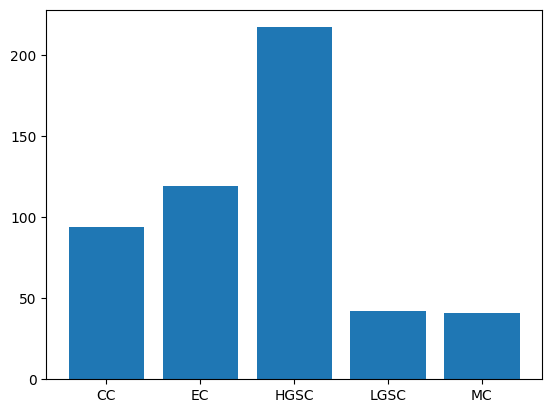

In [21]:
# class distibution in histogram
cancers, counts = np.unique(df_np[:,1], return_counts = True)
print(cancers, counts)
plt.bar(cancers, counts)

Looking at the bar graph above we can see for the WSI thumbnails the distibution is not fully balanced so when we split the data we will need to account for this

# Preprocessing, Tuning, & Configuration
-----

In this step the thumbnails need to receive tiles to put in the model. This will involve taking the image transforming it to produce another image:

rotation


In [45]:
epochs = 20
epoch = epochs
lossRate = .05
seed = 22
torch.manual_seed(seed)
bs = 16
verfSize = .1


def config(epochs_in = epochs, lr_in = lossRate, seed_in = seed, batch_size_in = bs):
    epochs = epochs_in
    lossRate = lr_in
    seed = seed_in
    torch.manual_seed(seed_in)
    bs = batch_size_in
    
config()

In [46]:
id_train, id_test, class_train, class_test = 0 , 0,0,0

In [47]:
def split_data(seed_in, print_values=False):
    id_train, id_verf,class_train,class_verf = train_test_split(df_np[:,0],df_np[:,1], test_size = verfSize, random_state = seed_in)
    if print_values == True:
        print(f"id_train:\n{id_train[:3]}\nclass_train:\n{class_train[:3]}\nid_verf:\n{id_verf[:3]}\nclass_verf:\n{class_verf[:3]}")
    return id_train, id_verf,class_train,class_verf

def filepathThumbs(files):
    pathfiles = []
    print(files)
    for i in range(files.shape[0]):
        pathfiles.append(f"/kaggle/input/UBC-OCEAN/train_thumbnails/{files[i-1]}_thumbnail.png")
    return pathfiles
# note potiential change could be chaging the distibution to be evenly or random instead of default

id_train, id_verf,class_train,class_verf = split_data(22,True)

id_train:
[59760 18896 15209]
class_train:
['EC' 'HGSC' 'HGSC']
id_verf:
[57162 22290 40129]
class_verf:
['LGSC' 'CC' 'CC']


In [48]:
def tileSelection(imgs, tile_type = 'r', tile_size = 260):
    files_list = filepathThumbs(imgs)
    num_files = len(files_list)
    out = np.zeros((num_files, tile_size, tile_size, 3), dtype=np.uint8)

    with tqdm(total=num_files, desc="Tiling images", unit="image") as pbar:
    
        for i, filex in enumerate(files_list):
            img = cv2.imread(filex)
            
            #here add more if statements for different tiling methods later on as a possible improvement to the model
            if tile_type == 'r':
                rand_row = random.randint(0, img.shape[0] - tile_size)
                rand_col = random.randint(0, img.shape[1] - tile_size)

                tile = img[rand_row:rand_row + tile_size, rand_col:rand_col + tile_size, :]

                out[i, :, :, :] = tile
                
            pbar.update(1)

    return out


#rand_set_thumb = tileSelection(id_train)
#here chagning the tile size might help to improve the results of the model built        

In [49]:
train_tiles = tileSelection(id_train)
verf_tiles = tileSelection(id_verf)

[59760 18896 15209 64950 31297 43432 52438 6449 56500 3997 1660 51893
 20316 54928 46815 32432 32636 44232 47984 8213 34247 22155 7482 33984
 8985 46139 27747 5015 53098 16986 5265 21373 33976 10469 30508 20312
 41099 36678 33708 7329 38901 60287 63121 52846 59900 51128 38349 49281
 61424 26025 47020 38687 20463 26862 15293 44700 3084 40079 21303 43998
 39208 11263 60936 19157 42296 53900 39893 6359 38849 64188 61961 35792
 48550 35909 35998 10143 10077 56117 57598 34649 52420 63941 34277 10548
 38585 24023 29904 3672 24759 50712 26533 50589 11559 14424 39146 65300
 431 6363 39172 3511 38479 56843 21929 58895 66 54825 4963 52275 18138
 1295 63015 7204 39425 47431 47105 38669 34845 31300 9509 1774 57711 21432
 4211 19569 52108 29615 38118 57100 48861 27950 58974 44530 61689 25331
 51346 40888 16042 16494 53688 20882 53059 42260 53402 28922 15583 51679
 30539 9183 18568 30712 54990 28028 55876 3055 5852 46435 38041 43280
 21260 37655 41801 15742 22489 45578 25923 23796 65371 38018 5114 5

Tiling images: 100%|██████████| 461/461 [01:19<00:00,  5.78image/s]


[57162 22290 40129 28562 3098 59002 18196 17291 31473 43815 15231 36204
 55279 59383 15188 38366 65533 3264 281 26124 39365 12442 15671 60685
 19030 20670 4877 30792 47960 32596 12244 22924 53377 63165 2666 26644
 28121 18810 30203 286 42549 63897 61852 58947 54473 34720 15912 26190
 14127 8279 52784 28393]


Tiling images: 100%|██████████| 52/52 [00:07<00:00,  7.33image/s]


In [50]:
train_tiles.shape

(461, 260, 260, 3)

In [51]:
class dataset(Dataset):
    def __init__(self, tiled_images, labels, transform=None):
        self.tiled_images = tiled_images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.tiled_images)

    def __getitem__(self, idx):
        tiled_image = self.tiled_images[idx]
        label = self.labels[idx]
        if self.transform:
            tiled_image = self.transform(tiled_image)

        return tiled_image, label
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
    

In [52]:
label_encoder = LabelEncoder()

class_train = torch.tensor(label_encoder.fit_transform(class_train), dtype=torch.float32)
class_verf = torch.tensor(label_encoder.fit_transform(class_verf), dtype=torch.float32)



In [54]:

train_dataset = dataset(train_tiles, class_train,transform)
val_dataset = dataset(verf_tiles, class_verf,transform)




In [55]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False)

# Model Setup
--------
Below is where the model is created and setup 
#insert more about timm model

In [56]:
class cancerClassifier(nn.Module):
    def __init__(self):
        super(cancerClassifier,self).__init__()
        self.num_classes = 5
        self.model = timm.create_model('tf_efficientnet_b2', in_chans=3,checkpoint_path='/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b2/1/tf_efficientnet_b2_aa-60c94f97.pth', pretrained = False)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 5)
        
        
    def forward(self, X):
        return self.model(X)



In [57]:
model = cancerClassifier()
print(model)

cancerClassifier(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), str

# Model Training

In [58]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lossRate)


In [59]:
plt.ion()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
t_hist = []
v_hist = []
total_correct_train = 0
total_samples_train = 0
model.to(device)



for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct_train = 0
    total_samples_train = 0
    print(f"Epoch {epoch + 1}\n===============")

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.to(torch.long)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.update(1)
            
            _, predictions_train = torch.max(outputs, 1)
            total_correct_train += (predictions_train == labels).sum().item()
            total_samples_train += labels.size(0)

        average_loss = total_loss / len(train_loader)
        
        average_loss_train = total_loss / len(train_loader)
        accuracy_train = total_correct_train / total_samples_train
        t_hist.append(accuracy_train)
        
        print(f"training accuracy: {accuracy_train}")
        

    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0

        for inputs, labels in val_loader:
            
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.to(torch.long)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

        accuracy = total_correct / total_samples
        
        v_hist.append(accuracy)
        
    print(f"validation accuracy : {accuracy}")


Epoch 1


Epoch 1/20: 100%|██████████| 29/29 [01:14<00:00,  2.58s/batch]


training accuracy: 0.30151843817787416
validation accuracy : 0.09615384615384616
Epoch 2


Epoch 2/20: 100%|██████████| 29/29 [01:15<00:00,  2.62s/batch]


training accuracy: 0.3036876355748373
validation accuracy : 0.2692307692307692
Epoch 3


Epoch 3/20: 100%|██████████| 29/29 [01:17<00:00,  2.68s/batch]


training accuracy: 0.3318872017353579
validation accuracy : 0.40384615384615385
Epoch 4


Epoch 4/20: 100%|██████████| 29/29 [01:15<00:00,  2.59s/batch]


training accuracy: 0.3492407809110629
validation accuracy : 0.40384615384615385
Epoch 5


Epoch 5/20: 100%|██████████| 29/29 [01:14<00:00,  2.57s/batch]


training accuracy: 0.42516268980477223
validation accuracy : 0.40384615384615385
Epoch 6


Epoch 6/20: 100%|██████████| 29/29 [01:15<00:00,  2.61s/batch]


training accuracy: 0.420824295010846
validation accuracy : 0.3269230769230769
Epoch 7


Epoch 7/20: 100%|██████████| 29/29 [01:14<00:00,  2.58s/batch]


training accuracy: 0.42516268980477223
validation accuracy : 0.3269230769230769
Epoch 8


Epoch 8/20: 100%|██████████| 29/29 [01:15<00:00,  2.62s/batch]


training accuracy: 0.42516268980477223
validation accuracy : 0.21153846153846154
Epoch 9


Epoch 9/20: 100%|██████████| 29/29 [01:15<00:00,  2.61s/batch]


training accuracy: 0.3318872017353579
validation accuracy : 0.40384615384615385
Epoch 10


Epoch 10/20: 100%|██████████| 29/29 [01:14<00:00,  2.58s/batch]


training accuracy: 0.40130151843817785
validation accuracy : 0.40384615384615385
Epoch 11


Epoch 11/20: 100%|██████████| 29/29 [01:14<00:00,  2.57s/batch]


training accuracy: 0.34273318872017355
validation accuracy : 0.40384615384615385
Epoch 12


Epoch 12/20: 100%|██████████| 29/29 [01:15<00:00,  2.62s/batch]


training accuracy: 0.3492407809110629
validation accuracy : 0.40384615384615385
Epoch 13


Epoch 13/20: 100%|██████████| 29/29 [01:14<00:00,  2.59s/batch]


training accuracy: 0.40563991323210413
validation accuracy : 0.21153846153846154
Epoch 14


Epoch 14/20: 100%|██████████| 29/29 [01:16<00:00,  2.63s/batch]


training accuracy: 0.38177874186550975
validation accuracy : 0.40384615384615385
Epoch 15


Epoch 15/20: 100%|██████████| 29/29 [01:14<00:00,  2.58s/batch]


training accuracy: 0.42516268980477223
validation accuracy : 0.40384615384615385
Epoch 16


Epoch 16/20: 100%|██████████| 29/29 [01:14<00:00,  2.56s/batch]


training accuracy: 0.4229934924078091
validation accuracy : 0.40384615384615385
Epoch 17


Epoch 17/20: 100%|██████████| 29/29 [01:14<00:00,  2.57s/batch]


training accuracy: 0.40130151843817785
validation accuracy : 0.36538461538461536
Epoch 18


Epoch 18/20: 100%|██████████| 29/29 [01:15<00:00,  2.59s/batch]


training accuracy: 0.42950108459869846
validation accuracy : 0.28846153846153844
Epoch 19


Epoch 19/20: 100%|██████████| 29/29 [01:14<00:00,  2.58s/batch]


training accuracy: 0.41865509761388287
validation accuracy : 0.40384615384615385
Epoch 20


Epoch 20/20: 100%|██████████| 29/29 [01:14<00:00,  2.58s/batch]


training accuracy: 0.42516268980477223
validation accuracy : 0.40384615384615385


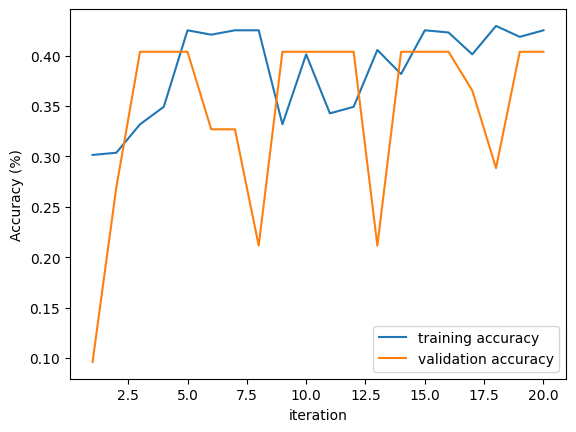

In [62]:
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],t_hist, label = "training accuracy")
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],v_hist, label = "validation accuracy")
plt.xlabel("iteration")
plt.ylabel("Accuracy (%)")
plt.legend()